# SVM Classifier
### In this part, SVM is used as a classifier instead of a softmax.

In [1]:
from __future__ import division
import os
import cv2
import imp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from alexnetG2 import AlexNet
import sklearn
import sklearn.svm as svm
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

## Classes declaration for image processing

In [2]:
pd.set_option('display.max_rows', 500000)
%matplotlib inline
imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)
current_dir = os.getcwd()
image_dir = os.path.join(current_dir, 'images')
CSV_FilePath = "./FilePathTable.csv"
num_classes = 2
class PathDetails:
    
    def __init__ (self, Path):
        self.PathDF = pd.read_table(Path, sep = ',')  # Converts the csv to DF format
 
    def Get_ImgPath_FilePath(self):
        df = self.PathDF
        fpath = './'+df.ImgListPath_Dir.head(1).values [0] +'/'+df.ImgListPath_File_Name.head(1).values [0]
        return (fpath)
        
    def Get_ChkPoint_FilePath(self,i):
        df = self.PathDF
        fpath = './'+df.Checkpoint_Root_Dir.values [i] +'/' + df.Classifier_Root_Dir.values [i]
        return (fpath)
        
    def Get_ChkPointModel_FilePath(self,i):
        df = self.PathDF
        fpath = './'+df.Checkpoint_Root_Dir.values [i] +'/' + df.Classifier_Root_Dir.values [i] +'/' + df.Classifier_Model_Path.values [i] 
        return (fpath)

    def Get_CaffClassName_FilePath(self,i):
        df = self.PathDF
        fpath = './'+df.Checkpoint_Root_Dir.values [i] +'/' + df.Classifier_Root_Dir.values [i] +'/' + df.CaffeClassNames_File.values [i] 
        return (fpath)    

class ImgDetails:
    
    def __init__ (self,Path):

        img_path_list = []
        imgs = []
        lables = []

        with open(Path, 'r') as img_files:
            # Load all images
            for i, f in enumerate (img_files):
                img_path,lable = f.split(' ')
                img_path_list.append(img_path)
                imgs.append(cv2.imread(img_path))
                lables.append(lable)
        img_files.close
        self.img_path_list = img_path_list
        self.imgs = imgs
        self.lables = lables      

class Seed_Classifier_St3:
    
    def __init__(self):

        self.Initialization_Flag = False
        
    def Initialize_Dataframes(self, path):
        
        self.Path = path
        self.Initialization_Flag = True
        self.Load_DF()
        self.Create_ActiveDF()
        print ("Successful: Initialize_Dataframes")
        
    def Initialization_Check(self):
        
        if not(self.Initialization_Flag): 
            print ("ERROR: Dataframe not initalised. Please run Initialise_Dataframes(<PATH>)")
            return 0
        return 1
       
    def Load_DF (self):
        
        if not (self.Initialization_Check()): return 
        path=self.Path
        self.Loaded_Data = pd.read_table(path, delim_whitespace=True, 
                             names=('Path',
                                    'Set', 
                                    'Prediction', 
                                    'Probability',
                                    'Expectation'),
                             dtype={'Set': np.str, 'Prediction': np.float64, 'Probability': np.float64, 'Expectation': np.float64}) 
        self.Load_DF_Status=True
        print ("Successful: Load_DF")
        
    def  Create_ActiveDF(self):
        
        # Get data
        if not (self.Initialization_Check()): return 
        Loaded_Data=self.Loaded_Data
        
        # Setting Active_df
        Active_df = pd.DataFrame(columns =['Path',
                                    'Category',
                                    'Img_Name',
                                    'Set', 
                                    'ClassifierName',
                                    'Prediction', 
                                    'Probability',
                                    'Expectation'])
        # Active_df +++>
        # Path, Set, Prediction, Probability, Expectation
        Active_df.Path=Loaded_Data.Path
        Active_df.Set=Loaded_Data.Set
        Active_df.Prediction=Loaded_Data.Prediction
        Active_df.Probability=Loaded_Data.Probability
        Active_df.Expectation=Loaded_Data.Expectation

        # Category, Img_Name
        t_path_stack = Loaded_Data.Path.str.split('/', expand=True).stack()
        Active_df.Category = t_path_stack[:, 7]
        Active_df.Img_Name = t_path_stack[:, 8]

        # ClassifierName
        Active_df.ClassifierName ='Classifier' + Loaded_Data.Set 
        self.Active_df = Active_df
        print("Successful: Create_Active_DF")
        
        
    def Create_TProbabilityColLabels(self):
        
        if not (self.Initialization_Check()): return 
        # Create a Confusion matrix for an image
        data = {'Prediction':[1,2,6,7],
                'Classifier1312':np.zeros(4),
                'Classifier2316':np.zeros(4),
                'Classifier3317':np.zeros(4),
                'Classifier4326':np.zeros(4),
                'Classifier5327':np.zeros(4),
                'Classifier6367':np.zeros(4),
               }
        print ("Successful: Create_TProbabilityColLabels")
        return data  
      
    def Create_PredictionResultDfColLabels(self):
        
        if not (self.Initialization_Check()): return 
        # Create a result matrix for an image
        data = {'Class1':np.zeros(1),
                'Class2':np.zeros(1),
                'Class6':np.zeros(1),
                'Class7':np.zeros(1),
                'Prediction':np.zeros(1),
                'Probability':np.zeros(1),
               }
        print ("Successful: Create_PredictionResultDfColLabels")
        return data 
    
    def Get_TotalProbability(self, name):
        
        if not (self.Initialization_Check()): return 
        # Initialise
        iname = name
        df = self.Active_df

        # Create a total probability matrix for an image
        Lables = self.Create_TProbabilityColLabels()
        Probability_Df = pd.DataFrame(Lables)

        # Iteration over the rows of prediction for that image
        Selected_Img_df = self.Search_Img(iname)
        for index, Selected_Row in Selected_Img_df.iterrows():
            Relative_Index =  Probability_Df.index[Probability_Df['Prediction'] == Selected_Row.Prediction]
            Probability_Df.at[Relative_Index,Selected_Row.ClassifierName] =  Selected_Row.Probability
        
        # Obtain the mean from the probs. from the 6 classifiers
        IndividualProbs = Probability_Df.iloc[:, 1:8]
        Probability_Df ['Total_Probability'] = IndividualProbs.mean(axis=1)
        print ("Successful: Get_TotalProbability")
        print ("Successful: Individual")
        print(IndividualProbs)
        return Probability_Df
  
    def Get_PredictionResult(self, name):
        
        # Initialization check
        if not (self.Initialization_Check()): return 
        
        # Create a prediction result df for an image
        Probability_Table = self.Get_TotalProbability(name)        
        temp = Probability_Table.iloc[Probability_Table['Total_Probability'].idxmax()]
        Lables = self.Create_PredictionResultDfColLabels()
        PredictionResult = pd.DataFrame(Lables)
   
        # Assign Probability
        PredictionResult['Class1']=Probability_Table.iloc[Probability_Table.index[Probability_Table.Prediction==1] [0]]['Total_Probability']
        PredictionResult['Class2']=Probability_Table.iloc[Probability_Table.index[Probability_Table.Prediction==2] [0]]['Total_Probability']
        PredictionResult['Class6']=Probability_Table.iloc[Probability_Table.index[Probability_Table.Prediction==6] [0]]['Total_Probability']
        PredictionResult['Class7']=Probability_Table.iloc[Probability_Table.index[Probability_Table.Prediction==7] [0]]['Total_Probability']
        PredictionResult['Probability']=temp.Total_Probability
        PredictionResult['Prediction']=temp.Prediction
        print ("Successful: Get_PredictionResult")
        return PredictionResult
     
    def Get_UniqueImgList(self):
        """Creates a list of names of images in the dataframe"""
        
        # Initialization check
        if not (self.Initialization_Check()): return 
        
        # Generate List
        Active_df=self.Active_df
        Img_Name_List= list (Active_df['Img_Name'].unique())
        print ("Successful: Get_UniqueImgList")
        return Img_Name_List
              
    def Search_Img(self,name):
        
        # Initialization check
        if not (self.Initialization_Check()): return 
        
        # Using Active_df
        df = self.Active_df
        Selected_Img_df = df[df.Img_Name==name]
        if Selected_Img_df.empty: print('ERROR: DataFrame is empty! \nSuggestion: Please check your image name.')
        return Selected_Img_df
        
    def PrintToFile_Active_df(self,path):
        
        # Initialization check
        if not (self.Initialization_Check()): return 
        
        Active_df=self.Active_df
        os.remove('./Path/Active_df.csv') if os.path.exists('./Path/Active_df.csv') else None
        Active_df.to_csv(r'./Path/Active_df.csv', header=('Path',
                                            'Category',
                                            'Img_Name',
                                            'Set', 
                                            'ClassifierName',
                                            'Prediction', 
                                            'Probability',
                                            'Expectation'), 
                                            index=None, sep=',', mode='a')
        print ("Successful: PrintToFile_Active_df") 

class Analyse_PredictionResults:    

    def __init__(self):

        self.Initialization_Flag=False
        self.Table=pd.DataFrame()
    
    def Extract_ImgInfo(self, ImgDetails, Prediction_Probability):
        df = Prediction_Probability
        df['Path'] = ImgDetails.Path.values [0]
        df['Category'] = ImgDetails.Category.values [0]
        df['Img_Name'] = ImgDetails.Img_Name.values [0]
        df['Expectation'] = ImgDetails.Expectation.values [0]
        df['Match'] = (df['Prediction'] == df['Expectation']) # Match check
        return df
    
    def Append_ToTable(self,df):
        self.Table = self.Table.append(df)
        print ("Successful: Append_ToTable")
        
    def SaveTo_CSV(self):   
        if (self.Table.size.size > 0): 
            self.Table.to_csv('./Result-FPSC3/St3_Prediction_Table.csv',sep = ' ')
            print("Successful: Table was saved.")
        else:
            print("ERROR: Table not save as the Table is empty.")

## Display image Dataframe

In [3]:
PathDB = PathDetails(CSV_FilePath) # Separates the contents of the csv. accordingly
ImgList_FilePath = PathDB.Get_ImgPath_FilePath() # Gets the image file path
ImgDB = ImgDetails(ImgList_FilePath) # Loads the images into array from the given path
PathDB.PathDF

,ImgListPath_Dir,ImgListPath_File_Name,Checkpoint_Root_Dir,Classifier_Root_Dir,Classifier_Model_Path,CaffeClassNames_File
0,Path,PStestAllCombined_Uniq.txt,Checkpoints,Checkpoint_1312,model_epoch500.ckpt.meta,caffe_classes_plamseed.py
1,Path,PStestAllCombined_Uniq.txt,Checkpoints,Checkpoint_2316,model_epoch500.ckpt.meta,caffe_classes_plamseed.py
2,Path,PStestAllCombined_Uniq.txt,Checkpoints,Checkpoint_3317,model_epoch500.ckpt.meta,caffe_classes_plamseed.py
3,Path,PStestAllCombined_Uniq.txt,Checkpoints,Checkpoint_4326,model_epoch500.ckpt.meta,caffe_classes_plamseed.py
4,Path,PStestAllCombined_Uniq.txt,Checkpoints,Checkpoint_5327,model_epoch500.ckpt.meta,caffe_classes_plamseed.py
5,Path,PStestAllCombined_Uniq.txt,Checkpoints,Checkpoint_6367,model_epoch500.ckpt.meta,caffe_classes_plamseed.py


## Load checkpoint and make predictions

In [4]:
%%time
x = tf.placeholder(tf.float32, [1, 227, 227, 3])
keep_prob = tf.placeholder(tf.float32)

i = 0
Model_Path = PathDB.Get_ChkPointModel_FilePath(i)
CheckpointDir_Path = PathDB.Get_ChkPoint_FilePath(i)
sess = tf.InteractiveSession()
saver = tf.train.import_meta_graph(Model_Path)
saver.restore(sess, tf.train.latest_checkpoint(CheckpointDir_Path))
saved_dict = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

model = AlexNet(x, keep_prob, num_classes, [], saved_dict, load_pretrained_weight = True)

# Creating images, labels and empty arrays
images = ImgDB.imgs
labels = ImgDB.lables

# Output Scores
scorefeatures1 = [] 
scorefeatures2 = []
scorefeatures3 = []
scorefeatures4 = []
scorefeatures5 = []
scorefeatures6 = []

# Predicted Labels
labelfeatures1 = [] 
labelfeatures2 = [] 
labelfeatures3 = [] 
labelfeatures4 = [] 
labelfeatures5 = [] 
labelfeatures6 = [] 

# Actual Labels
actualLabels = []

# Loop for each checkpoint
for i in range(0, 6): 
    
    # Setting variable values
    original_class_lable = ''
    Model_Path = PathDB.Get_ChkPointModel_FilePath(i)
    CheckpointDir_Path = PathDB.Get_ChkPoint_FilePath(i)
    ClassFile_Path = PathDB.Get_CaffClassName_FilePath(i)
    print(CheckpointDir_Path)
    
    ClassNameModule = imp.load_source('class_names', ClassFile_Path)
    class_names = ClassNameModule.class_names
    saver = tf.train.import_meta_graph(Model_Path)
    saver.restore(sess,tf.train.latest_checkpoint(CheckpointDir_Path))
    saved_dict = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    print('Loading checkpoint = ', i)
    
    # Load the pretrained weights into the model
    model.load_initial_weights(sess)
    score = model.fc8
    softmax = tf.nn.softmax(score)
    
    # Loop over all images
    for j, (image, label) in enumerate(zip(images, labels)):
        
        img = cv2.resize(image.astype(np.float32), (227, 227))
        img = img - imagenet_mean
        img = img.reshape((1, 227, 227, 3)) 
        layer8scoreVector = sess.run(softmax, feed_dict={x: img, keep_prob: 1}) # Returns 1 x 2  array
        
        # Separates the 6 classifier scores for each SVM. i represents the classifier
        if i == 0:
            scorefeatures1.append(layer8scoreVector) # Appends into an array
        elif i == 1:
            scorefeatures2.append(layer8scoreVector)
        elif i == 2:
            scorefeatures3.append(layer8scoreVector)  
        elif i == 3:
            scorefeatures4.append(layer8scoreVector) 
        elif i == 4:
            scorefeatures5.append(layer8scoreVector)
        elif i == 5:
            scorefeatures6.append(layer8scoreVector)

INFO:tensorflow:Restoring parameters from ./Checkpoints/Checkpoint_1312/model_epoch500.ckpt
./Checkpoints/Checkpoint_1312
INFO:tensorflow:Restoring parameters from ./Checkpoints/Checkpoint_1312/model_epoch500.ckpt
Loading checkpoint =  0
Loading Pretrained weight.
./Checkpoints/Checkpoint_2316
INFO:tensorflow:Restoring parameters from ./Checkpoints/Checkpoint_2316/model_epoch500.ckpt
Loading checkpoint =  1
Loading Pretrained weight.
./Checkpoints/Checkpoint_3317
INFO:tensorflow:Restoring parameters from ./Checkpoints/Checkpoint_3317/model_epoch500.ckpt
Loading checkpoint =  2
Loading Pretrained weight.
./Checkpoints/Checkpoint_4326
INFO:tensorflow:Restoring parameters from ./Checkpoints/Checkpoint_4326/model_epoch500.ckpt
Loading checkpoint =  3
Loading Pretrained weight.
./Checkpoints/Checkpoint_5327
INFO:tensorflow:Restoring parameters from ./Checkpoints/Checkpoint_5327/model_epoch500.ckpt
Loading checkpoint =  4
Loading Pretrained weight.
./Checkpoints/Checkpoint_6367
INFO:tensorfl

In [13]:
%%time
# Initilize Dataframe
# Parameter: none
newresult = './finalpath_rabbi.csv'
myDF = Seed_Classifier_St3()
_ = myDF.Initialize_Dataframes(newresult)

# List of images 
# Parameter: myDF
myImg_Name_List = myDF.Get_UniqueImgList()

# Creating a DF to analyse the result
Analyse_ResultDF=Analyse_PredictionResults()

for iname in myImg_Name_List:
    
    # Get the max probability for prediction
    PredictionResult_DF = myDF.Get_PredictionResult(iname)

    # Get current image details
    ImageDetails_DF = myDF.Search_Img(iname)
    
    # Converting the dataframe into a suitable format
    # so that it can be added as row
    Row = Analyse_ResultDF.Extract_ImgInfo(ImageDetails_DF,PredictionResult_DF)
    _ = Analyse_ResultDF.Append_ToTable(Row)
    
# Save result
_ = Analyse_ResultDF.SaveTo_CSV()


Successful: Load_DF
Successful: Create_Active_DF
Successful: Initialize_Dataframes
Successful: Get_UniqueImgList
Successful: Create_TProbabilityColLabels
Successful: Get_TotalProbability
Successful: Individual
   Classifier1312  Classifier2316  Classifier3317  Classifier4326  \
0             1.0          0.9999             1.0             0.0   
1             0.0          0.0000             0.0             0.0   
2             0.0          0.0000             0.0             1.0   
3             0.0          0.0000             0.0             0.0   

   Classifier5327  Classifier6367  
0          0.0000             0.0  
1          0.6507             0.0  
2          0.0000             1.0  
3          0.0000             0.0  
Successful: Create_PredictionResultDfColLabels
Successful: Get_PredictionResult
Successful: Append_ToTable
Successful: Create_TProbabilityColLabels
Successful: Get_TotalProbability
Successful: Individual
   Classifier1312  Classifier2316  Classifier3317  Classifie

   Classifier1312  Classifier2316  Classifier3317  Classifier4326  \
0             1.0          0.9999          0.9999             0.0   
1             0.0          0.0000          0.0000             0.0   
2             0.0          0.0000          0.0000             1.0   
3             0.0          0.0000          0.0000             0.0   

   Classifier5327  Classifier6367  
0          0.0000          0.0000  
1          0.0000          0.0000  
2          0.0000          0.9796  
3          0.9822          0.0000  
Successful: Create_PredictionResultDfColLabels
Successful: Get_PredictionResult
Successful: Append_ToTable
Successful: Create_TProbabilityColLabels
Successful: Get_TotalProbability
Successful: Individual
   Classifier1312  Classifier2316  Classifier3317  Classifier4326  \
0             1.0             1.0             1.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             1

Successful: Append_ToTable
Successful: Create_TProbabilityColLabels
Successful: Get_TotalProbability
Successful: Individual
   Classifier1312  Classifier2316  Classifier3317  Classifier4326  \
0             0.0             0.0             0.0             0.0   
1             1.0             0.0             0.0             0.0   
2             0.0             1.0             0.0             1.0   
3             0.0             0.0             1.0             0.0   

   Classifier5327  Classifier6367  
0          0.0000             0.0  
1          0.0000             0.0  
2          0.0000             1.0  
3          0.9977             0.0  
Successful: Create_PredictionResultDfColLabels
Successful: Get_PredictionResult
Successful: Append_ToTable
Successful: Create_TProbabilityColLabels
Successful: Get_TotalProbability
Successful: Individual
   Classifier1312  Classifier2316  Classifier3317  Classifier4326  \
0          0.0000          0.0000          0.0000             0.0   
1       

Successful: Get_TotalProbability
Successful: Individual
   Classifier1312  Classifier2316  Classifier3317  Classifier4326  \
0             0.0          0.9999             0.0             0.0   
1             1.0          0.0000             0.0             1.0   
2             0.0          0.0000             0.0             0.0   
3             0.0          0.0000             1.0             0.0   

   Classifier5327  Classifier6367  
0           0.000             0.0  
1           0.993             0.0  
2           0.000             0.0  
3           0.000             1.0  
Successful: Create_PredictionResultDfColLabels
Successful: Get_PredictionResult
Successful: Append_ToTable
Successful: Create_TProbabilityColLabels
Successful: Get_TotalProbability
Successful: Individual
   Classifier1312  Classifier2316  Classifier3317  Classifier4326  \
0             0.0          0.9975          0.6866             0.0   
1             1.0          0.0000          0.0000             1.0   
2      

   Classifier1312  Classifier2316  Classifier3317  Classifier4326  \
0             1.0             0.0          0.9795             0.0   
1             0.0             0.0          0.0000             0.0   
2             0.0             1.0          0.0000             1.0   
3             0.0             0.0          0.0000             0.0   

   Classifier5327  Classifier6367  
0             0.0             0.0  
1             0.0             0.0  
2             0.0             1.0  
3             1.0             0.0  
Successful: Create_PredictionResultDfColLabels
Successful: Get_PredictionResult
Successful: Append_ToTable
Successful: Create_TProbabilityColLabels
Successful: Get_TotalProbability
Successful: Individual
   Classifier1312  Classifier2316  Classifier3317  Classifier4326  \
0             1.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             1.0             0.0             1

Successful: Get_TotalProbability
Successful: Individual
   Classifier1312  Classifier2316  Classifier3317  Classifier4326  \
0          0.0000             0.0          0.9036             0.0   
1          0.8091             0.0          0.0000             0.0   
2          0.0000             1.0          0.0000             1.0   
3          0.0000             0.0          0.0000             0.0   

   Classifier5327  Classifier6367  
0          0.0000             0.0  
1          0.8247             0.0  
2          0.0000             1.0  
3          0.0000             0.0  
Successful: Create_PredictionResultDfColLabels
Successful: Get_PredictionResult
Successful: Append_ToTable
Successful: Create_TProbabilityColLabels
Successful: Get_TotalProbability
Successful: Individual
   Classifier1312  Classifier2316  Classifier3317  Classifier4326  \
0             1.0             0.0            0.99             0.0   
1             0.0             0.0            0.00             0.0   
2      

   Classifier1312  Classifier2316  Classifier3317  Classifier4326  \
0          0.9605          0.0000          0.0000             0.0   
1          0.0000          0.0000          0.0000             0.0   
2          0.0000          0.9329          0.0000             1.0   
3          0.0000          0.0000          0.9998             0.0   

   Classifier5327  Classifier6367  
0          0.0000          0.0000  
1          0.0000          0.0000  
2          0.0000          0.0000  
3          0.8099          0.9458  
Successful: Create_PredictionResultDfColLabels
Successful: Get_PredictionResult
Successful: Append_ToTable
Successful: Create_TProbabilityColLabels
Successful: Get_TotalProbability
Successful: Individual
   Classifier1312  Classifier2316  Classifier3317  Classifier4326  \
0             0.0          0.0000             0.0             0.0   
1             1.0          0.0000             0.0             0.0   
2             0.0          0.9996             0.0             1

## Create training dataset Dataframe

In [6]:
# Convert all score to np. arrray
npscore1 = np.array(scorefeatures1)
npscore2 = np.array(scorefeatures2)
npscore3 = np.array(scorefeatures3)
npscore4 = np.array(scorefeatures4)
npscore5 = np.array(scorefeatures5)
npscore6 = np.array(scorefeatures6)
maxClass1, maxClass2, maxClass3, maxClass4, maxClass5, maxClass6 = ([] for i in range(6))

# Use zip to quickly iterate over many list 
for i, (v1, v2, v3, v4, v5, v6) in enumerate(zip(npscore1, npscore2, npscore3, npscore4, npscore5, npscore6)):
    maxClass1.append(np.argmax(v1)) # np.argmax return the index of predicted class
    maxClass2.append(np.argmax(v2))
    maxClass3.append(np.argmax(v3))
    maxClass4.append(np.argmax(v4))
    maxClass5.append(np.argmax(v5))
    maxClass6.append(np.argmax(v6))    

# Individual scores 
npscore1flatten = npscore1.reshape(-1, 2)
npscore2flatten = npscore2.reshape(-1, 2)
npscore3flatten = npscore3.reshape(-1, 2)
npscore4flatten = npscore4.reshape(-1, 2)
npscore5flatten = npscore5.reshape(-1, 2)
npscore6flatten = npscore6.reshape(-1, 2)

maxClass1 = np.array(maxClass1)
maxClass2 = np.array(maxClass2)
maxClass3 = np.array(maxClass3)
maxClass4 = np.array(maxClass4)
maxClass5 = np.array(maxClass5)
maxClass6 = np.array(maxClass6)

# Combined scores
total6scoresArray = np.concatenate((npscore1flatten, npscore2flatten, npscore3flatten, npscore4flatten, npscore5flatten, npscore6flatten), axis=0)
total6labelsArray = np.concatenate((maxClass1, maxClass2, maxClass3, maxClass4, maxClass5, maxClass6), axis=0)  

# Changing each predictions to its correct classes, brute force way
for i, value in enumerate(maxClass1):
    if value == 1:
        maxClass1[i]=2
    elif value == 0:
        maxClass1[i]=1
for i, value in enumerate(maxClass2):
    if value == 1:
        maxClass2[i]=6
    elif value == 0:
        maxClass2[i]=1
for i, value in enumerate(maxClass3):
    if value == 1:
        maxClass3[i]=7
    elif value == 0:
        maxClass3[i]=1
for i, value in enumerate(maxClass4):
    if value == 1:
        maxClass4[i]=6
    elif value == 0:
        maxClass4[i]=2
for i, value in enumerate(maxClass5):
    if value == 1:
        maxClass5[i]=7
    elif value == 0:
        maxClass5[i]=2
for i, value in enumerate(maxClass6):
    if value == 1:
        maxClass6[i]=6
    elif value == 0:
        maxClass6[i]=7
        
total6scoresArray = np.concatenate((npscore1flatten, npscore2flatten, npscore3flatten, npscore4flatten, npscore5flatten, npscore6flatten), axis=0)
total6labelsArray = np.concatenate((maxClass1, maxClass2, maxClass3, maxClass4, maxClass5, maxClass6), axis=0) 

# Create a dataframe for easier indexing
scoresDF = [[np.around(np.array(npscore1flatten), 4), maxClass1, npscore1flatten.shape, 'Class 12'], 
            [np.around(np.array(npscore2flatten), 4), maxClass2, npscore2flatten.shape, 'Class 16'], 
            [np.around(np.array(npscore3flatten), 4), maxClass3, npscore3flatten.shape, 'Class 17'], 
            [np.around(np.array(npscore4flatten), 4), maxClass4, npscore4flatten.shape, 'Class 26'], 
            [np.around(np.array(npscore5flatten), 4), maxClass5, npscore5flatten.shape, 'Class 27'], 
            [np.around(np.array(npscore6flatten), 4), maxClass6, npscore6flatten.shape, 'Class 67'],
            [total6scoresArray, total6labelsArray, total6scoresArray.shape, 'All Class']]
df = pd.DataFrame(scoresDF, columns=['Softmax Scores','Predicted Labels','Shape','Class'])
df

,Softmax Scores,Predicted Labels,Shape,Class
0,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(128, 2)",Class 12
1,"[[0.9999, 1e-04], [1.0, 0.0], [1.0, 0.0], [0.9...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, ...","(128, 2)",Class 16
2,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, ...","(128, 2)",Class 17
3,"[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","(128, 2)",Class 26
4,"[[0.6507, 0.3493], [0.0, 1.0], [0.0213, 0.9787...","[2, 7, 7, 7, 2, 7, 2, 7, 7, 2, 7, 7, 7, 2, 7, ...","(128, 2)",Class 27
5,"[[1.0, 0.0], [0.0659, 0.9341], [1.0, 0.0], [1....","[7, 6, 7, 7, 7, 6, 7, 6, 7, 7, 7, 7, 7, 7, 7, ...","(128, 2)",Class 67
6,"[[1.0, 5.6217136e-27], [1.0, 3.2134943e-14], [...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(768, 2)",All Class


## Train SVM

In [7]:
%%time
### There is a small trade off between the C parameters and the hyperplane
modelSVM1 = svm.SVC(kernel='linear', C=100)
modelSVM1.fit(df['Softmax Scores'][0], df['Predicted Labels'][0])

modelSVM2 = svm.SVC(kernel='linear', C=100)
modelSVM2.fit(df['Softmax Scores'][1], df['Predicted Labels'][1])

modelSVM3 = svm.SVC(kernel='linear', C=100)
modelSVM3.fit(df['Softmax Scores'][2], df['Predicted Labels'][2])

modelSVM4 = svm.SVC(kernel='linear', C=100)
modelSVM4.fit(df['Softmax Scores'][3], df['Predicted Labels'][3])

modelSVM5 = svm.SVC(kernel='linear', C=100)
modelSVM5.fit(df['Softmax Scores'][4], df['Predicted Labels'][4])

modelSVM6 = svm.SVC(kernel='linear', C=100)
modelSVM6.fit(df['Softmax Scores'][5], df['Predicted Labels'][5])

# Fit all the scores with the corresponding 4 labels, train time increases with C
modelSVMALL = svm.SVC(kernel='linear', C=1)
modelSVMALL.fit(df['Softmax Scores'][6], df['Predicted Labels'][6])

CPU times: user 11.1 ms, sys: 5.39 ms, total: 16.5 ms
Wall time: 23.7 ms


## Load testing images 

In [8]:
# Predict the class of a new image using our trained model
CSV_FilePath_test = "./testingSVM.csv" # Test file path
PathDB_test = PathDetails(CSV_FilePath_test)
ImgList_FilePath_test = PathDB_test.Get_ImgPath_FilePath()
ImgDB_test = ImgDetails(ImgList_FilePath_test)
Tscorefeatures1 = []

# Loop over all images
for jTest, imageTest in enumerate(ImgDB_test.imgs):

    img = cv2.resize(imageTest.astype(np.float32), (227,227))   
    img = img - imagenet_mean
    img = img.reshape((1, 227, 227, 3))
    img = np.array(img).astype(np.float32)
    scoreVector = sess.run(softmax, feed_dict={x: img, keep_prob: 1}) # Obtain softmax of image
    Tscorefeatures1.append(scoreVector) # append all the scores
TestSVM = np.array(Tscorefeatures1).reshape(-1, 2)

## Testing SVM and final accuracy

In [9]:
%%time
actualTestLabbels = ImgDB_test.lables
TestLabels = [i.strip() for i in actualTestLabbels]
TestLabels = np.array(TestLabels).flatten()
predictedTestALL = modelSVMALL.predict(TestSVM)
predictedLabelsTest = []

# Changing all the labels to correct ones
for i, v1 in enumerate(TestSVM):
    predictedLabelsTest.append(np.argmax(v1))
predictedLabel = np.array(predictedLabelsTest)
actualLabel = np.array([int(i) for i in actualTestLabbels]).ravel()
test1 = predictedLabel[0:116]
for i, value in enumerate(test1):
    if value == 1:
        test1[i]=2
    elif value == 0:
        test1[i]=1
test2 = predictedLabel[116:160]
for i, value in enumerate(test2):
    if value == 1:
        test2[i]=2
    elif value == 0:
        test2[i]=1
test6 = predictedLabel[160:292]
for i, value in enumerate(test6):
    if value == 0:
        test6[i] = 6
    elif value == 1:
        test6[i]= 0
test7 = predictedLabel[292:]
for i, value in enumerate(test7):
    if value == 0:
        test7[i] = 0
    elif value == 1:
        test7[i] = 7
PredictedTestClass = np.concatenate((test1, test2, test6, test7))
totalAcc = np.mean(np.array(PredictedTestClass).ravel()==np.array(actualLabel).ravel()) * 100
print('Final Accuracy =', totalAcc)


Final Accuracy = 93.26145552560648
CPU times: user 4.96 ms, sys: 7.83 ms, total: 12.8 ms
Wall time: 27.2 ms


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

## Plot SVM
### *This is only for graphing purpose to see the decision boundary

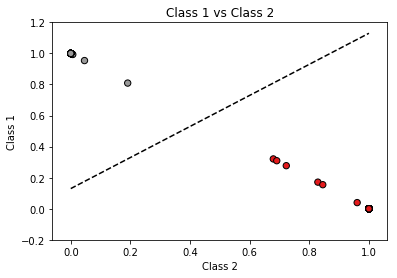

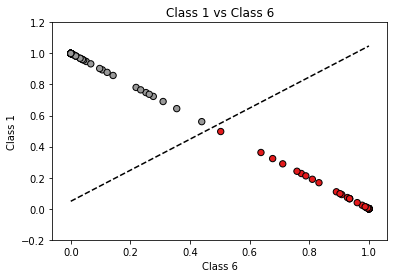

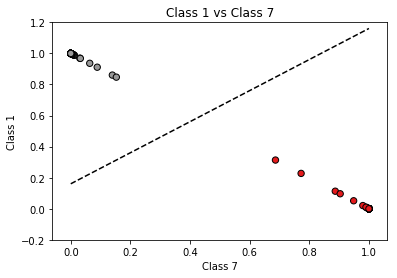

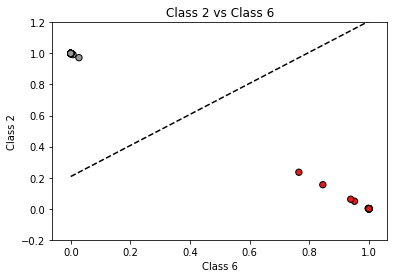

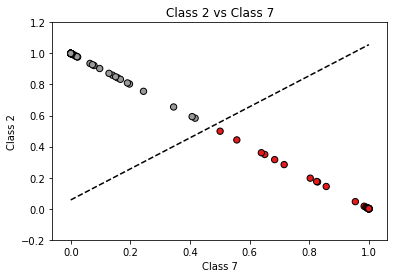

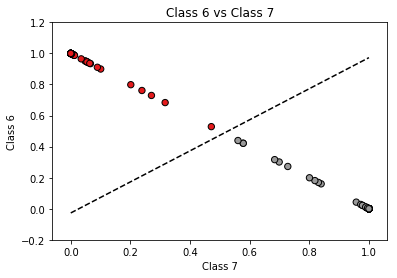

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

def plotSVM(svmModel, flatscores, flatlabels, title):
    w = svmModel.coef_[0] # Trained support vectors
    a = -w[0] / w[1]
    xx = np.linspace(np.min(flatscores), np.max(flatscores))
    yy = a * xx - (svmModel.intercept_[0]) / w[1]
    plt.plot(xx, yy, 'k--')
    plt.scatter(flatscores[:, 0], flatscores[:, 1], c=flatlabels, s=40, marker='o', cmap=plt.cm.Set1, edgecolor='k')
    # Uncomment the line below for support vector points
    #plt.scatter(svmModel.support_vectors_[:, 0], svmModel.support_vectors_[:, 1], s=100, marker='x', edgecolor='k')
    plt.ylim(np.min(flatscores) - 0.2, np.max(flatscores) + 0.2)
    plt.ylabel(title[0:7])
    plt.xlabel(title[11:18])
    plt.title(title)
    plt.show()
plotSVM(modelSVM1, npscore1flatten, maxClass1, 'Class 1 vs Class 2')
plotSVM(modelSVM2, npscore2flatten, maxClass2, 'Class 1 vs Class 6')
plotSVM(modelSVM3, npscore3flatten, maxClass3, 'Class 1 vs Class 7')
plotSVM(modelSVM4, npscore4flatten, maxClass4, 'Class 2 vs Class 6')
plotSVM(modelSVM5, npscore5flatten, maxClass5, 'Class 2 vs Class 7')
plotSVM(modelSVM6, npscore6flatten, maxClass6, 'Class 6 vs Class 7')

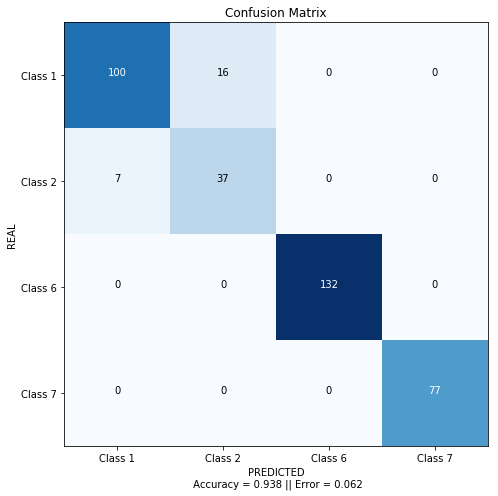

SVM Accuracy = 93.26145552560648


In [12]:
import itertools
def plot_confusion_matrix(cm, target_names, title = 'Confusion Matrix', cmap = None, normalize = True):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize = (7, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    if target_names is not None:
        target_names = ['Class 1', 'Class 2', 'Class 6', 'Class 7'] # Use string names
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('REAL')
    plt.xlabel('PREDICTED\n Accuracy = {:0.3f} || Error = {:0.3f}'.format(accuracy, misclass))
    plt.tight_layout()
    plt.show()

    
PredSVM = (np.array(PredictedTestClass)).ravel()
TrueSVM = actualLabel.ravel()
cm = confusion_matrix(actualLabel.ravel(), PredictedTestClass, labels = [1, 2, 6, 7]) # 4 classes
plot_confusion_matrix(cm, [1, 2, 6, 7], normalize=False) # Normalize to get probs. 
print('SVM Accuracy =', np.mean(PredSVM == TrueSVM) * 100.0)